In [3]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
load_dotenv()

engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
    .format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))

## Make Prime table in DB

In [3]:
df = pd.read_csv("prime.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

df.to_sql(name="prime_rates", con= engine, if_exists='replace', index=False)

query_mod_date_col = """ALTER TABLE `sba`.`prime_rates` 
CHANGE COLUMN `DATE` `DATE` DATE NOT NULL ,
ADD UNIQUE INDEX `DATE_UNIQUE` (`DATE` ASC);
;"""

engine.execute(query_mod_date_col)

# query to add date and year columns for easier joins
add_mth_year_queries = []
add_mth_year_queries.append(sa.text("ALTER TABLE prime_rates ADD COLUMN p_MONTH int NULL AFTER date ;"))
add_mth_year_queries.append(sa.text("ALTER TABLE prime_rates ADD COLUMN p_YEAR int NULL AFTER date ;"))
add_mth_year_queries.append(sa.text("UPDATE prime_rates SET prime_rates.p_MONTH = MONTH(prime_rates.`DATE`);"))
add_mth_year_queries.append(sa.text("UPDATE prime_rates SET prime_rates.p_YEAR = YEAR(prime_rates.`DATE`);"))

                # INSERT INTO prime_rates(month) FROM prime_rates;
for q in add_mth_year_queries:
    engine.execute(q)

prime_df = pd.read_sql("SELECT * FROM sba.prime_rates",engine)

In [4]:
prime_annual = prime_df[prime_df.columns[1:]].groupby('p_YEAR').mean()[['PRIME']].reset_index()
prime_annual = prime_annual[prime_annual['p_YEAR']>=2000]
prime_df = prime_df[prime_df['p_YEAR']>=2000]

## Read in loan data, format dates

In [5]:
loan_df = pd.read_sql('SELECT * FROM clean_version', con=engine)
date_cols = [c for c in loan_df.columns if 'Dt' in c]
for c in date_cols:
    loan_df[c] = pd.to_datetime(loan_df[c])
loan_df['Note_Yr'] = loan_df['NoteDt'].dt.year
loan_df['Note_Mth'] = loan_df['NoteDt'].dt.month
first_cols = ['GP','Note_Yr','Note_Mth'] 
formatted_order = first_cols + [c for c in loan_df.columns if c not in first_cols]
loan_df = loan_df[formatted_order] 
loan_df.head()
test_df = loan_df[loan_df['MatBucket']=='21+']
gp_checks = loan_df[loan_df['PrepayMthsQty']==0]['GP'].to_list()

for gp in gp_checks: 
    failed_gps = []
    gp_query = f"SELECT EffectiveDt, TransactionBalanceAmt from FIN_FINAL where ObservationNmb = {gp} AND GeneralLedgerCd in (6031,1510) ORDER BY EffectiveDt;"
    test_gp = pd.read_sql(gp_query, engine)
    # case_1 --> where there are two instances of the balance being zero:
    zero_counts= test_gp[test_gp['TransactionBalanceAmt']==0].shape[0]
    if zero_counts > 1:
        failed_gps.append(gp)
    else:
    # case_2 --> where there is one zero but the loan is still outstanding
        if test_gp.tail(1)['TransactionBalanceAmt'].values[-1]>0:
        # action for case_2 --> go to table and change the PrepayDt column and PrepayMthsQty Column to Null
            loan_df.loc[loan_df['GP']==gp,'PrepayMthsQty'] = np.nan
            loan_df.loc[loan_df['GP']==gp,'PrepayDt'] = pd.NaT


In [6]:
# loan_df.to_sql("clean_version_2", engine, if_exists="replace")

In [7]:
loan_df = pd.read_csv('clean_loans.csv')
loan_df = loan_df[[c for c in loan_df.columns if 'unnamed' not in c.lower()] ]

In [8]:
def coalesce_least(row):
    a = row['PrepayMthsQty']
    b = row['DefaultMthsQty']
    if pd.isnull(a):
        return b
    elif pd.isnull(b):
        return a
    else:
        return min(a, b)
    
loan_df['PP_Qty'] = loan_df[['PrepayMthsQty','DefaultMthsQty']].apply(coalesce_least, axis=1)



In [9]:
test_df = loan_df[loan_df['MatBucket']=='8-11']

test_df['Distance_to_Maturity'] = test_df['MaturityMthsQty'] - test_df['PP_Qty']

test_df = test_df[test_df['Distance_to_Maturity'].notna()]

bins = [0,12,24,48,60,72,np.inf]
test_df['mths_remaining_bucket'] = pd.cut(test_df['Distance_to_Maturity'], bins=bins)


mths_remaining = test_df[test_df['PP_Qty']>=60].groupby('mths_remaining_bucket').count()[['GP']].reset_index()


mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].astype(str)
mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].str.replace('\(','')
mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].str.replace(',',' -')
mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].str.replace(']','')
mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].str.replace('- inf','+')




In [10]:

# bins = [0,12,24,48,60,72,np.inf]
# test_df['MoB_bucket'] = pd.cut(test_df['PP_Qty'], bins=bins)

# mob = test_df.groupby('MoB_bucket').count()[['GP']].reset_index()

# mob['MoB_bucket'] = mob['MoB_bucket'].astype(str)
# mob['MoB_bucket'] = mob['MoB_bucket'].str.replace('\(','')
# mob['MoB_bucket'] = mob['MoB_bucket'].str.replace(',',' -')
# mob['MoB_bucket'] = mob['MoB_bucket'].str.replace(']','')
# mob['MoB_bucket'] = mob['MoB_bucket'].str.replace('- inf','+')
# mob.to_csv('mob_8-11.csv')

## Do Year cut-off on WAL

<AxesSubplot: xlabel='Note_Yr,Note_Mth'>

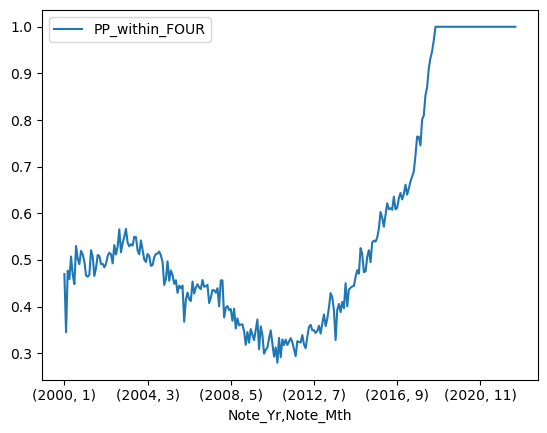

In [11]:
group_df = test_df[['Note_Yr','Note_Mth','PP_Qty']].groupby(['Note_Yr','Note_Mth'])['PP_Qty'].agg(total_count= 'count', PP_within_FOUR= lambda x: x[x<=48].count()/len(x), \
                                                    PP_within_SEVEN= lambda x: x[x<=86].count()/len(x) )

group_df[['PP_within_FOUR']].plot()

## WAL Charts and grouping

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def wal(grp):
    return ( round((grp['LoanAmt'] * grp['PP_Qty']).sum() / grp['LoanAmt'].sum() /12, 2) )  



def get_prime_rate(grp, p_df:pd.DataFrame)-> float:
    temp_df = p_df[p_df['yr']==grp['yr']]
    values = temp_df[temp_df['mth']==grp['mth']]['PRIME'].values
    if len(values)>0:
        if values[-1] > 10:
            display(temp_df[temp_df['mth']==grp['mth']])
        return values[-1]
    else:
        mth_to_find = grp['mth']
        for idx, temp_row in temp_df.iterrows():
            if temp_row['mth'] > mth_to_find and idx > 0:
                if temp_df.at[idx,'PRIME'] > 10: 
                    display(temp_df.iloc[idx, 'PRIME'])
                return temp_df.at[idx,'PRIME']                

        

if 'Note_Yr' in test_df.columns:
    test_df = test_df.rename(columns={'Note_Yr':'yr','Note_Mth':'mth'})
    
wal_groups = test_df[['GP','yr','mth','LoanAmt','PP_Qty']].groupby(['yr','mth'])[['LoanAmt','PP_Qty']].apply(wal)
wal_groups = pd.DataFrame(wal_groups)

wal_groups = wal_groups.rename(columns={0: 'wal'}).reset_index()
# create a grouped prime df (indexed on year and month)
prime_df = prime_df.rename(columns={'p_YEAR':'yr', 'p_MONTH':'mth'})
prime = prime_df.groupby(['yr','mth']).last()[['PRIME']].reset_index()

new_col = []
for _, row in wal_groups[['yr','mth']].iterrows():
    new_col.append(  get_prime_rate(row, prime))

wal_groups['PRIME'] = pd.Series(new_col)
# # create a multiindex with all possible yr mth combos
# full_index = pd.MultiIndex.from_product([list(range(wal_groups['yr'].min(),wal_groups['yr'].max()+1)), list(range(1,13)) ]  ) 
# wal_groups = wal_groups.set_index(['yr','mth'])
# # ffill the prime df with new index
# prime = prime.set_index(['yr','mth']).reindex(full_index).ffill().reset_index().rename(columns={'level_0':'yr'	,'level_1':'mth'}).set_index(['yr','mth']).fillna(method='bfill')
# # join prime rate data on weighted average life data
# wal_groups = wal_groups.merge(prime,left_index=True, right_index=True)
# wal_groups = wal_groups.reset_index()

In [13]:
wal_groups

,yr,mth,wal,PRIME
0,2000,1,4.92,9.00
1,2000,2,5.35,8.75
2,2000,3,4.66,9.00
3,2000,4,4.77,9.50
4,2000,5,4.49,9.50
...,...,...,...,...
267,2022,4,0.41,4.00
268,2022,5,0.18,4.00
269,2022,6,0.16,4.75
270,2022,7,0.08,5.50


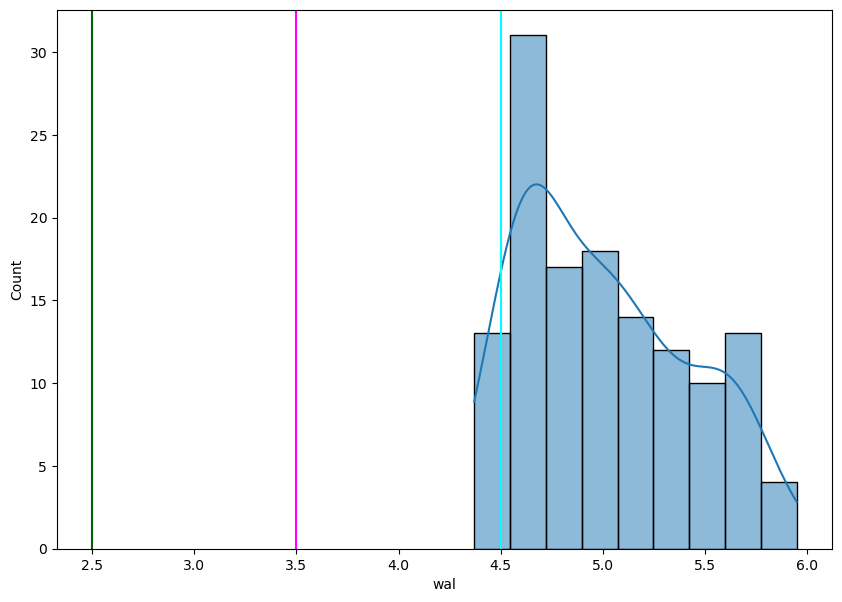

In [14]:
fig, ax = plt.subplots(figsize=(10,7))

g = sns.histplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=ax, kde=True)
g.axvline(x=2.5, color='darkgreen')
g.axvline(x=3.5, color='magenta')
g.axvline(x=4.5, color='cyan')


In [15]:
wal_groups[wal_groups['yr']<=2010].to_csv('for_mir.csv')

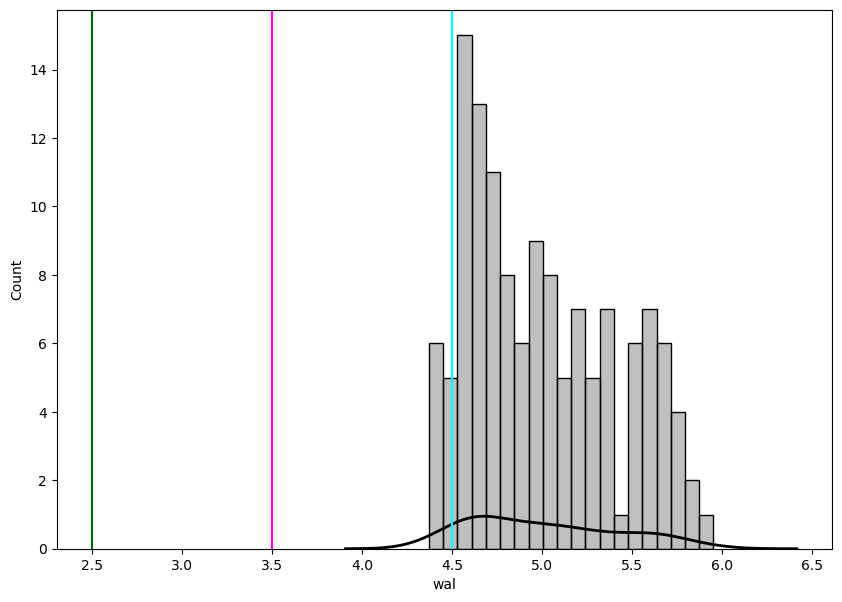

In [16]:
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=ax, kde=False, color='gray', bins=20, alpha=0.5)
sns.kdeplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=ax, color='black', linewidth=2)

ax.axvline(x=2.5, color='darkgreen')
ax.axvline(x=3.5, color='magenta')
ax.axvline(x=4.5, color='cyan')

plt.show()

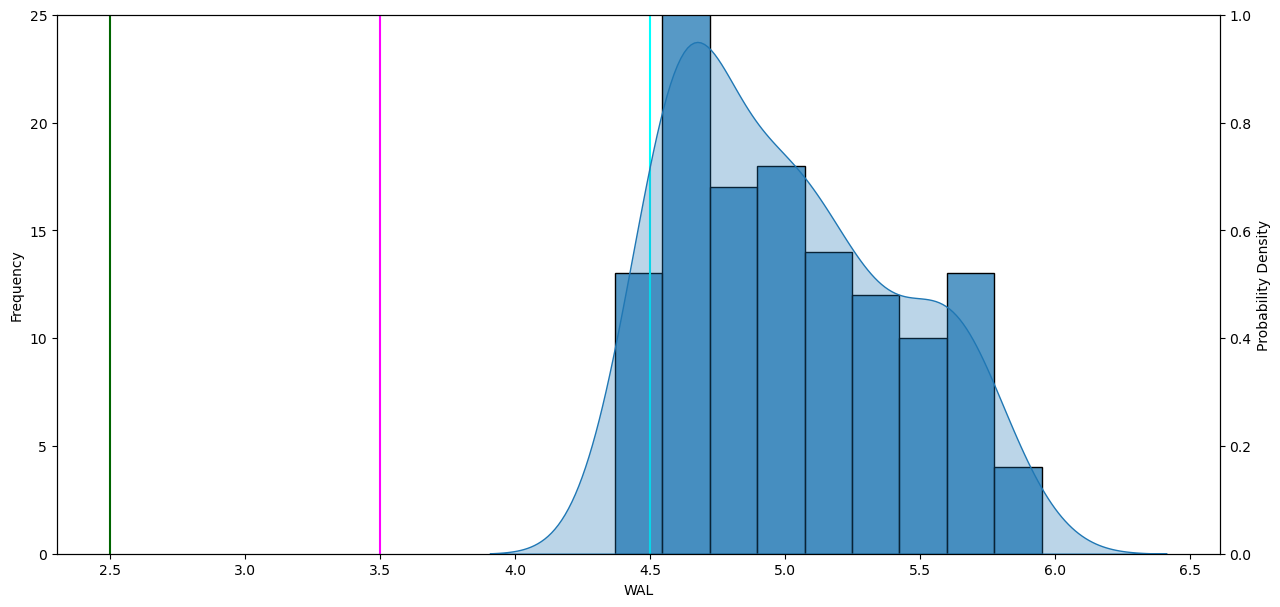

In [17]:
fig, ax = plt.subplots(figsize=(15,7))

# Plot histogram
sns.histplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=ax, kde=False)
ax.set_xlabel('WAL')
ax.set_ylabel('Frequency')
ax.set_ylim(0,25)
ax.axvline(x=2.5, color='darkgreen')
ax.axvline(x=3.5, color='magenta')
ax.axvline(x=4.5, color='cyan')
# Create secondary y-axis
sec_ax = ax.twinx()

# Plot KDE on secondary y-axis
sns.kdeplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=sec_ax, palette='Blues', fill=True, alpha=.3)
sec_ax.set_ylabel('Probability Density')

# Set y-limits for secondary y-axis
sec_ax.set_ylim(0, 1)

# # Add legend
# ax.legend(['Histogram'])
# sec_ax.legend(['KDE'], loc='upper right')

plt.show()

## WAL - Prime Rate Distribution with Break-Even REFLINE

[Text(0, 0.0, '0.00%'),
 Text(0, 2.0, '2.00%'),
 Text(0, 4.0, '4.00%'),
 Text(0, 6.0, '6.00%'),
 Text(0, 8.0, '8.00%'),
 Text(0, 10.0, '10.00%'),
 Text(0, 12.0, '12.00%')]

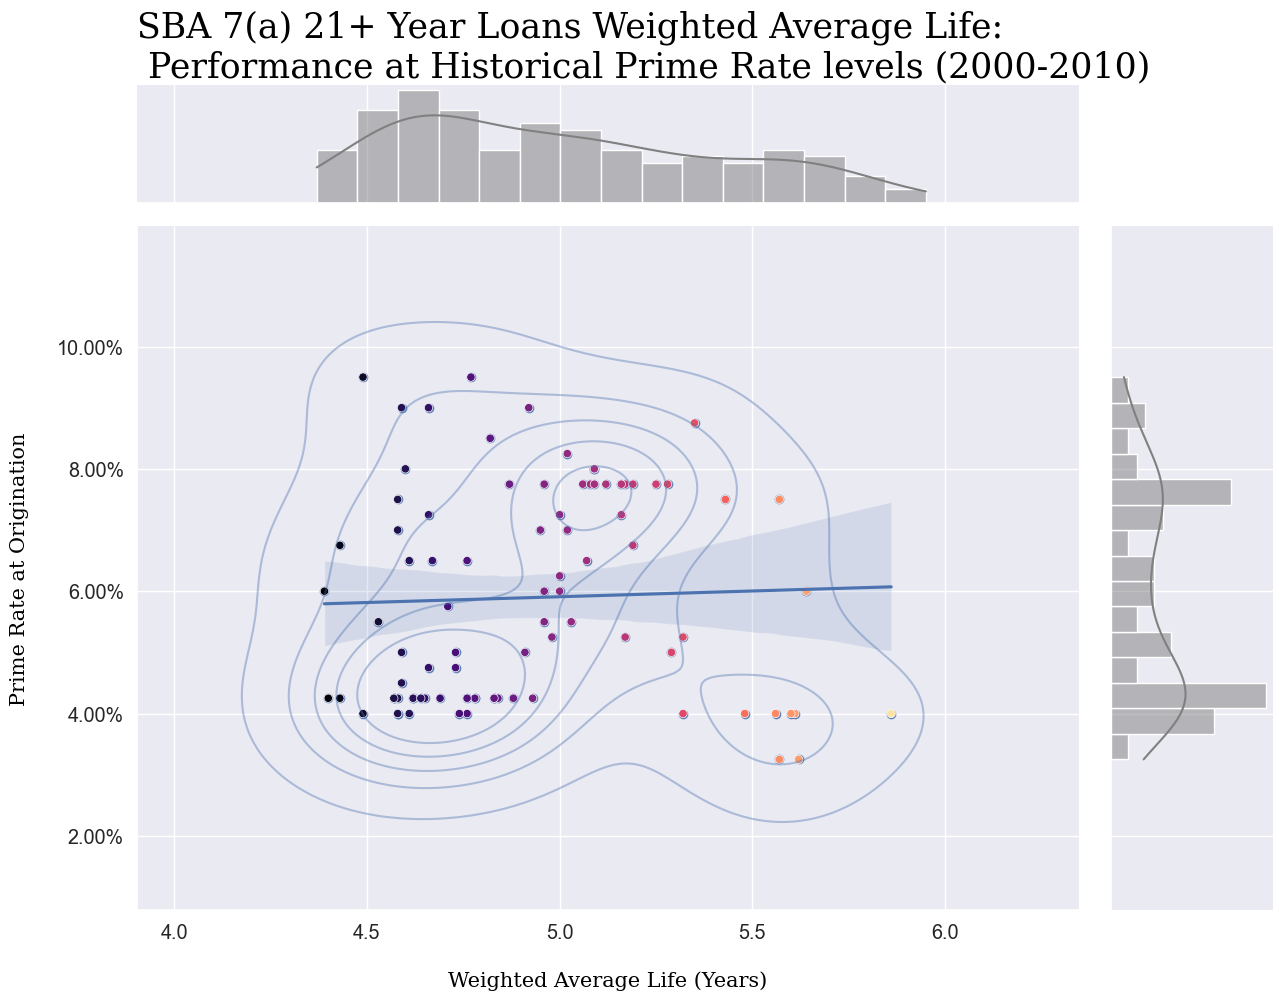

In [18]:
# Create a single plot
import matplotlib.pyplot as plt
font1 = {'family':'serif','color':'black','size':15}


font2 = {'family':'serif','color':'black','size':25}

sns.set_style("darkgrid")
sns.set_context("poster")
sns.set(font_scale=1.3)

g = sns.jointplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', y='PRIME', kind='reg', palette='viridis', marginal_kws=dict(bins=15,fill=True, color='gray'))
g = g.plot_joint(sns.kdeplot, levels=6, alpha=0.4, style='-')
g = g.plot_joint(sns.scatterplot, hue=wal_groups[wal_groups['yr']<=2010]['wal'], palette='magma', legend=False)
g.fig.set_size_inches(14,10)
g.set_axis_labels(xlabel='Weighted Average Life (Years)', ylabel='Prime Rate at Origination', fontdict=font1, labelpad = 20)
g.figure.axes[1].set_title('SBA 7(a) 21+ Year Loans Weighted Average Life:\n Performance at Historical Prime Rate levels (2000-2010)',loc='left', fontdict=font2)
# g.refline(x=2.5, color='darkgreen')
# g.refline(x=3.5, color='magenta')
# g.refline(x=4.5, color='cyan')
all_axes = [ax for ax in g.figure.axes]
vals = all_axes[0].get_yticks()
vals = [(v/100) for v in vals]
all_axes[0].set_yticklabels(['{:,.2%}'.format(x) for x in vals])

# ax.set_yticklabels(['{:,2%}'.format(x) for x in vals])


In [19]:
wal_groups

,yr,mth,wal,PRIME
0,2000,1,4.92,9.00
1,2000,2,5.35,8.75
2,2000,3,4.66,9.00
3,2000,4,4.77,9.50
4,2000,5,4.49,9.50
...,...,...,...,...
267,2022,4,0.41,4.00
268,2022,5,0.18,4.00
269,2022,6,0.16,4.75
270,2022,7,0.08,5.50


Text(0.5, 1.0, '21+ Year Maturity SBA 7(a)\n Weighted Average Life: 2000-2010')

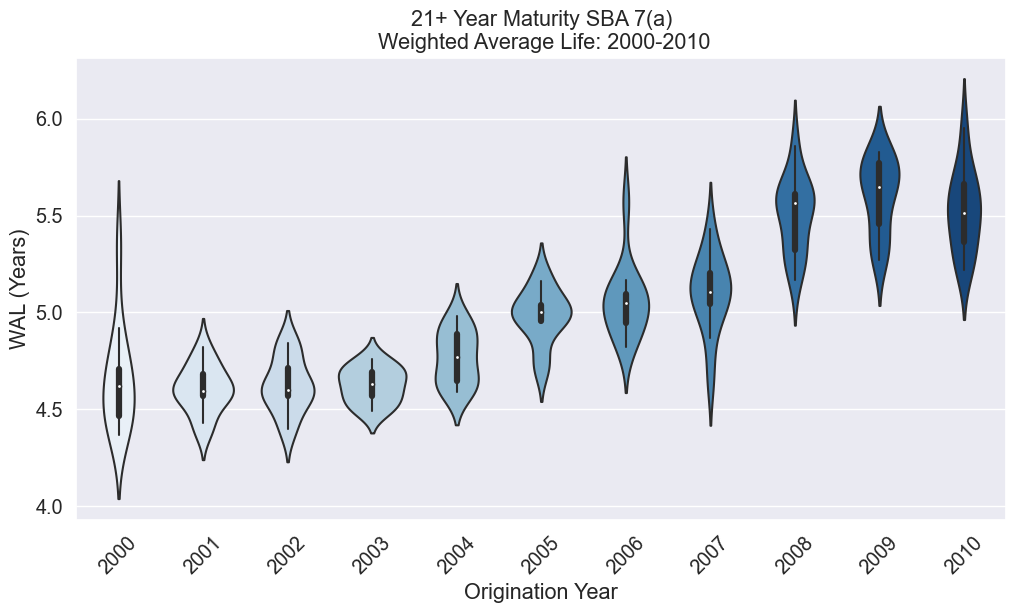

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,6))

g = sns.violinplot(x='yr', y='wal', data=wal_groups[wal_groups['yr']<=2010], palette='Blues')

# sns.lineplot(x='yr', y='PRIME',data=wal_groups[wal_groups['yr']<=2010], ax = ax2, legend=False)

plt.xticks(rotation=45)
plt.xlabel(xlabel='Origination Year')
plt.ylabel(ylabel="WAL (Years)")
plt.title(label="21+ Year Maturity SBA 7(a)\n Weighted Average Life: 2000-2010")



<AxesSubplot: ylabel='PRIME'>

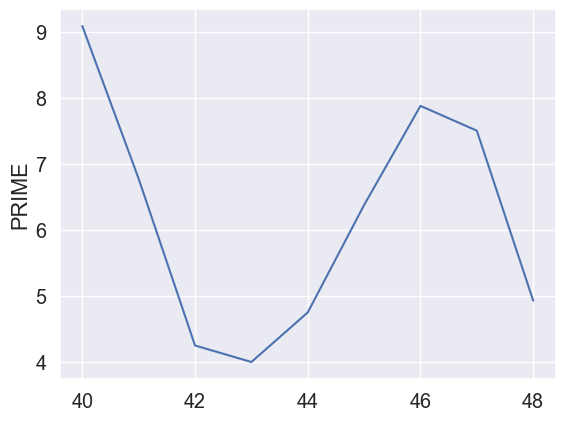

In [21]:
sns.lineplot(data=prime_annual[prime_annual['p_YEAR']<=2010]['PRIME'])

## Survivorship

In [22]:
test_df

,GP,yr,mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,MatBucket,PP_Qty,Distance_to_Maturity,mths_remaining_bucket
3,2022516,2001,2,2001-02-28,60000.00,2011-02-27,119,2011-09-13,NaN,2010-01-12,106.0,8-11,106.0,13.0,"(12.0, 24.0]"
19,2380966,2003,7,2003-07-31,137800.00,2012-01-31,102,2013-03-31,NaN,2011-02-01,90.0,8-11,90.0,12.0,"(0.0, 12.0]"
40,3994111,2004,12,2004-12-31,15000.00,2012-12-31,96,2012-06-15,89.0,2011-11-14,82.0,8-11,82.0,14.0,"(12.0, 24.0]"
55,4057302,2005,7,2005-07-31,75000.00,2013-10-14,98,2013-08-27,96.0,2013-06-21,94.0,8-11,94.0,4.0,"(0.0, 12.0]"
56,4062322,2005,10,2005-10-31,104682.16,2015-05-01,114,2015-10-14,NaN,2015-04-30,113.0,8-11,113.0,1.0,"(0.0, 12.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820114,15576485,2021,5,2021-05-21,330000.00,2031-04-21,119,2021-12-31,7.0,NaN,NaN,8-11,7.0,112.0,"(72.0, inf]"
820189,17968756,2021,7,2021-07-31,2018000.00,2031-07-30,119,2022-06-02,10.0,NaN,NaN,8-11,10.0,109.0,"(72.0, inf]"
820224,17975543,2021,8,2021-08-31,630000.00,2031-08-27,119,2021-12-31,4.0,NaN,NaN,8-11,4.0,115.0,"(72.0, inf]"
820308,17988416,2021,12,2021-12-06,100000.00,2031-11-05,118,2022-09-02,8.0,NaN,NaN,8-11,8.0,110.0,"(72.0, inf]"


In [23]:
# Group by year and month of origination
df_grouped = test_df.groupby(['yr', 'mth'])


def balance_rundown(grp):
    balance_dict = {}
    start_balance = grp['LoanAmt'].sum()
    balance_dict[0] = start_balance
    months_to_track = list(range(0, 121, 6))
    # Loop through each month and calculate balance rundown
    for month in months_to_track[1:]:
        # Remove loans with PP_Qty less than or equal to x months
        balance =round(grp.loc[(grp['PP_Qty'] > month) | (grp['PP_Qty'].isna()), 'LoanAmt'].sum(),2)
        # Add remaining balance to dictionary
        balance_dict[month] = balance
    
    return balance_dict


def loan_count(grp, date_str):
    loan_count_dict = {}
    n_loans = grp['GP'].count()
    loan_count_dict[0] = n_loans
    months_to_track = list(range(0, 252, 1))
    curr_time = dt.datetime.now()
    for month in months_to_track[1:]:
        test_date = pd.to_datetime(date_str) + np.timedelta64(month,'M')
        # conidition == FALSE if the test_date is LESS than the curr_date
        condition = test_date > curr_time
        if not condition:
        # Filter loans with PP_Qty greater than month or missing values
            outstanding_loans = grp.loc[(grp['PP_Qty'] > month) | (grp['PP_Qty'].isna())]
            # Count the number of outstanding loans
            n_outstanding_loans = outstanding_loans['GP'].count()
            # Add the number of outstanding loans to the dictionary
            loan_count_dict[month] = n_outstanding_loans
    return loan_count_dict

master_dict = {}
for name, grp in df_grouped:
    x = name
    yr = [y for y in x][0]
    mth = [y for y in x][1]

    date_str = f"{yr}-{mth}"
    master_dict[name] = loan_count(grp, date_str)
    

In [24]:
df_sample = pd.DataFrame(master_dict)
my_range = list(range(0,252,1))

# long way -- probs a way to vectorize this

data = {}
for idx, row in df_sample.transpose().iterrows():
    cohort_name = f"{idx[0]}-{idx[1]}"
    data_row = (row.to_list())
    survivorship = [round(100*(1-(data_row[0]-d)/data_row[0]), 3) for d in data_row]
    data[cohort_name] = survivorship
    


In [25]:
# pd.DataFrame(data).plot(figsize=(12,10), grid=True)
import plotly.express as px
surv = pd.DataFrame(data)

# fig = px.line(data_frame=surv, line_shape='linear')
# fig.show()
# surv.plot(figsize=(15,10), grid=True)

In [26]:
surv['mean'] = surv.mean(axis=1)
surv['stdev'] = surv.std(axis=1)
surv['+3sig']= surv['mean']+3*surv['stdev']
surv.loc[surv['+3sig']>100,'+3sig'] = 100
surv['-3sig']= surv['mean']-3*surv['stdev']
surv.loc[surv['-3sig']<0,'-3sig'] = 0

In [27]:
surv = surv.drop(columns='stdev')

In [28]:
surv[surv.columns[-3:]]

,mean,+3sig,-3sig
0,100.000000,100.0,100.000000
1,98.677239,100.0,71.076754
2,97.806375,100.0,64.525873
3,97.011548,100.0,60.087438
4,96.160452,100.0,53.377820
...,...,...,...
247,0.000000,0.0,0.000000
248,0.000000,0.0,0.000000
249,0.000000,0.0,0.000000
250,0.000000,0.0,0.000000


In [29]:
# sns.relplot(data=surv[surv.columns[-3:]], kind='line', height=8.27, aspect=11.7/8.27)

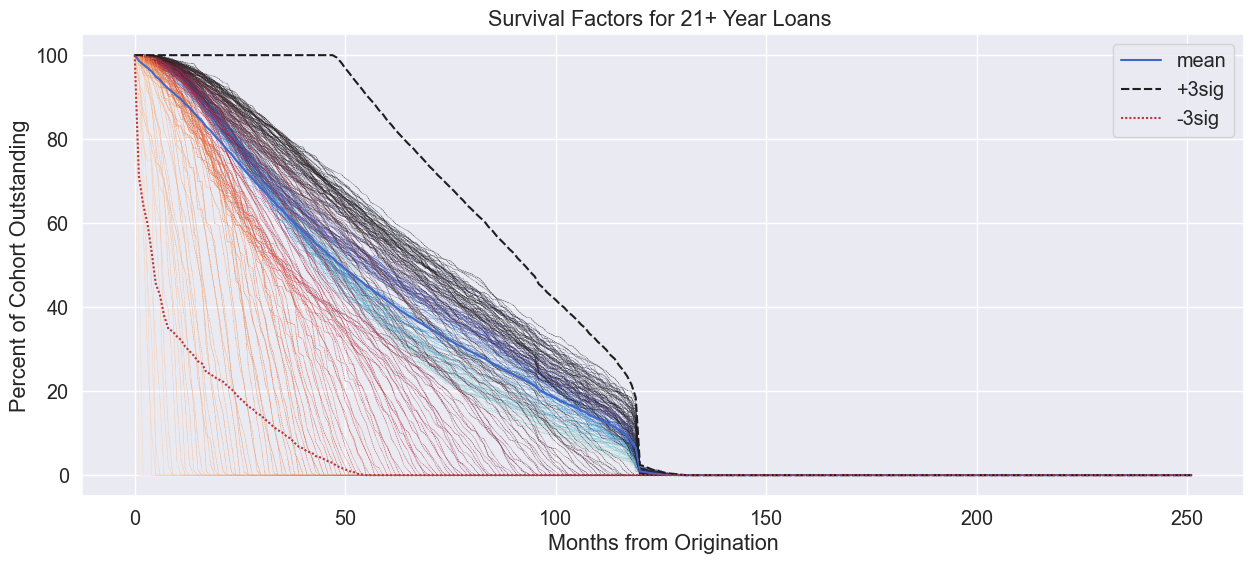

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a single plot
fig, ax = plt.subplots(figsize=(15, 6))

sns.set_style("darkgrid")

# all cohort survivorship
fig_1 =sns.lineplot(data=surv[surv.columns[:-4]], alpha=1, ax=ax, legend=False, palette="icefire", linewidth=.35)

# Plot the line chart on the same axis
sns.lineplot(data=surv[surv.columns[-3:]], palette='icefire')

# sns.color_palette("Paired")
# Add titles and labels to the plot
ax.set_title("Survival Factors for 21+ Year Loans ")
ax.set_xlabel("Months from Origination")
ax.set_ylabel("Percent of Cohort Outstanding")

# Show the plot
plt.show()

In [ ]:
q_5="""SELECT GP, naics_final.Code ,naics_final.CodeText, NoteDt, MaturityDt, MaturityMthsQty, coalesce(LoanAmt, elipsamt7afoia.GrossApprovalAmt) as LoanAmt, DATE(PrepayDt) as PrepayDt, PrepayMthsQty, DATE(DefaultDt) as DefaultDt, DefaultMthsQty from clean_version_2
LEFT JOIN elipsamt7afoia on elipsamt7afoia.ObservationNmb = clean_version_2.GP 
LEFT JOIN naics_final on naics_final.observationnmb = clean_version_2.GP ;"""



df = pd.read_sql(q_5, engine)

## NAICS aggregates for Ergkys and FIG modelling

In [192]:
import pandas as pd
import sqlalchemy as sa

In [219]:
df = pd.read_csv('../runthrough/raw_data/master_loan_tape.csv')
date_cols = [c for c in df.columns if str(c)[-2:]=='Dt']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])



(820500, 19)

In [220]:
df2 =  pd.read_csv('../runthrough/raw_data/clean_loans&codes.csv')


(739079, 21)

In [232]:
all_gps = set(df['GP'].to_list())
naics_gps = set(df2['GP'].to_list())
to_get = list(all_gps.difference(naics_gps))
to_get = df[df['GP'].isin(to_get)]
clean_frame = pd.concat([df2, to_get], axis=0)
clean_frame[clean_frame.columns[1:]].to_csv('../runthrough/raw_data/loans_v2.csv', index=False)

In [218]:
test = df[df['MatBucket']=='8-11']
print(test.shape[0])
print(test[test['MarginBucket'].isna()].shape[0])

262577
33162


In [215]:
test = df[df['MatBucket']=='8-11']
test = test[test['LoanAmt']<2_500_000]
test[test['Note_Yr']==2020].groupby(['Note_Yr','Note_Mth']).count()['GP']

Note_Yr  Note_Mth
2020     1           1027
         2            914
         3            912
         4            499
         5            716
         6            845
         7            857
         8            988
         9           1951
         10           669
         11           798
         12           706
Name: GP, dtype: int64

In [207]:
test = df[df['MatBucket']=='8-11']
test = test[test['Note_Yr']<=2021]
test[(test['Code'].isna())|(test['Code']<0)]

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,PP_qty,MatBucket,Code,CodeText,Margin,MarginBucket,state_abbreviation,state_name
163,4516009,2009,3,2009-03-31,5000.00,2019-03-31,120,2011-08-11,28.0,2010-06-14,14.0,14.0,8-11,NaN,NaN,0.04500,0.0275+,FL,Florida
165,4521071,2009,9,2009-09-30,12500.00,2019-09-30,120,2014-04-23,54.0,2012-01-10,27.0,27.0,8-11,NaN,NaN,0.04500,0.0275+,OR,Oregon
230,1494542,2000,5,2000-05-31,43000.00,2010-05-31,120,2001-02-01,8.0,NaT,NaN,8.0,8-11,NaN,NaN,0.01000,0.0 - 0.01,IA,Iowa
242,1497704,2000,5,2000-05-31,954000.00,2010-05-31,120,2002-03-26,21.0,2000-09-18,3.0,3.0,8-11,-1.0,NaN,0.02000,0.0175 - 0.02,IL,Illinois
262,475882,2000,6,2000-06-30,25000.00,2008-06-30,96,2000-08-31,2.0,NaT,NaN,2.0,8-11,-1.0,NaN,0.00275,0.0 - 0.01,GA,Georgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820315,17989821,2021,11,2021-11-30,340570.72,2031-11-30,120,NaT,NaN,NaT,NaN,NaN,8-11,NaN,NaN,0.02250,0.02 - 0.0225,OH,Ohio
820319,17990659,2021,11,2021-11-23,196600.00,2032-02-23,123,NaT,NaN,NaT,NaN,NaN,8-11,NaN,NaN,0.02750,0.025 - 0.0275,AL,Alabama
820325,17991714,2021,12,2021-12-31,95242.00,2031-12-29,119,NaT,NaN,NaT,NaN,NaN,8-11,NaN,NaN,0.03750,0.0275+,NY,New York
820326,17991919,2021,12,2021-12-31,150000.00,2031-12-07,119,NaT,NaN,NaT,NaN,NaN,8-11,NaN,NaN,0.02750,0.025 - 0.0275,FL,Florida


In [198]:
test = df[(df['Code'].isna())|(df['Code']<0)]

(81421, 19)

In [203]:
test[test['MatBucket']=='8-11'].groupby('Note_Yr').count()['GP'].to_csv('NAICS_new/missing_8-11.csv')

In [173]:
df = df[df['Code']>0]
df['yr'] = df['NoteDt'].dt.year

### define a function to get all the NAICS versions into a Dataframe

In [174]:
# versions in descending order
versions = ['22','17','12','07','02','97']
order = list(range(1,len(versions)+1))
# getter function
def get_naics_lookup_table(years:list)->pd.DataFrame:
    lookups = []
    for yr in years:
        table_name = f"naics_lookup{yr}"
        query  = f"SELECT * FROM {table_name}"
        look_up = pd.read_sql(query, engine)
        look_up['version']= yr
        lookups.append(look_up)

    return pd.concat(lookups, axis=0)
# pull 
code_lookup = get_naics_lookup_table(versions)
code_lookup['CodeText'] = code_lookup['CodeText'].str.strip() 
version_dict = dict(zip(versions,order[::-1]))
code_lookup['version_no'] = code_lookup['version'].map(version_dict)

In [175]:
temp = code_lookup[code_lookup['Code']==721110]
temp[temp['version_no']==temp['version_no'].max()]['CodeText'].values[0]

'Hotels (except Casino Hotels) and Motels'

### Map CodeText to the most recent Code

- Group the dataframe by code
- Three cases: 
    - The same code has multiple code texts
    - The same code text has multiple codes
    - A code has one code text -- i.e. no change required
- Solution: 
    - Create two hashtables that resolves each type of collision


In [176]:
def code_from_text(_text:str, lookup:pd.DataFrame)->int:
    temp= lookup[lookup['CodeText']==_text]
    max_vers = temp['version_no'].max()
    return temp[temp['version_no']==max_vers]['Code'].values[0]

def text_from_code(_code:int, lookup:pd.DataFrame)->str:
    temp= lookup[lookup['Code']==_code]
    max_vers = temp['version_no'].max()
    return temp[temp['version_no']==max_vers]['CodeText'].values[0]

In [178]:
def get_correct_version(_code:int, lookup:pd.DataFrame):
   
    temp = lookup[lookup['Code']==_code]
    temp_text = temp['CodeText'].values[0]
    temp = lookup[lookup['CodeText']==temp_text]
    max_vers = temp['version_no'].max()
    correct_code = temp[temp['version_no']==max_vers]['Code'].values[0]
    correct_text = temp[temp['version_no']==max_vers]['CodeText'].values[0]
    return correct_code, correct_text

In [182]:
from tqdm import tqdm

In [185]:
for idx, row in tqdm(df.iterrows()):
    df.loc[idx,'Code'], df.loc[idx,'CodeText'] = get_correct_version(row['Code'], code_lookup)
    
    

739079it [26:16, 468.72it/s]


In [190]:
# # possibley better code
# # Group the lookup DataFrame by 'CodeText' and find the row with the maximum 'version_no'
# max_version = lookup.groupby('CodeText')['version_no'].transform(max)

# # Filter the lookup DataFrame to only keep the rows with the maximum version number for each 'CodeText'
# lookup_filtered = lookup[lookup['version_no'] == max_version]

# # Merge the filtered lookup DataFrame with the original DataFrame to update the 'Code' and 'CodeText' columns
# df = pd.merge(df, lookup_filtered[['Code', 'CodeText', 'version_no']], on='CodeText', how='left')


In [187]:
df.to_csv('../runthrough/raw_data/clean_loans&codes.csv')

In [188]:
df_21 = df[df['MatBucket']=='21+']
df_811 = df[df['MatBucket']=='8-11']

In [191]:
df_811.groupby(['Note_Yr','Code']).agg({'CodeText':'first','LoanAmt':'sum','GP':'count'}).to_csv('NAICS_new/811_yearly.csv')

In [36]:
# Do an aggregation by Code
overall = df_811.groupby('Code').agg({'LoanAmt': 'sum', 'GP': 'count'}).sort_values('LoanAmt', ascending=False).reset_index()
merged = overall.merge(code_lookup[code_lookup['version']=='22'], on='Code', how='left')
incomplete = merged[merged['CodeText'].isna()]

# Go through all the versions and get the most recent version of the Code Text
complete = []
complete.append(merged[merged['CodeText'].notna()])
for v in versions[1:]:
    cols = [c for c in incomplete.columns.to_list() if c not in ['CodeText', 'version'] ]
    incomplete = incomplete[cols]
    incomplete = incomplete.merge(code_lookup[code_lookup['version']==v], on='Code', how='left')
    now_complete = incomplete[incomplete['CodeText'].notna()]
    complete.append(now_complete)
    incomplete = incomplete[incomplete['CodeText'].isna()]




In [37]:
pd.concat(complete).sort_values('GP',ascending=False)['CodeText'].value_counts()

Satellite Telecommunications                      2
Cellular and Other Wireless Telecommunications    2
Wired Telecommunications Carriers                 2
All Other Consumer Goods Rental                   2
All Other General Merchandise Stores              2
                                                 ..
Metal Stamping                                    1
Other Animal Food Manufacturing                   1
Payroll Services                                  1
Fuel Dealers                                      1
Livestock Wholesalers                             1
Name: CodeText, Length: 1297, dtype: int64

In [63]:
combined = pd.concat(complete).drop_duplicates(subset=['Code'])
# Strip trailing and leading whitespace
combined['CodeText'] = combined['CodeText'].str.strip()
# Get list of duplicate text fields
dupes = combined[combined['CodeText'].duplicated()]['CodeText'].values
# split out data into clean and duplicates
duplicated = combined[combined['CodeText'].isin(dupes)]
clean = combined[~combined['CodeText'].isin(dupes)]
# combine duplicates
duplicated = duplicated.groupby(['CodeText']).agg({'version':'first','Code':'first','LoanAmt':'sum', 'GP':'sum'}).reset_index()

# rejoin clean with cleaned up duplicates
clean = pd.concat([clean,duplicated[clean.columns]],axis=0)
clean.to_csv('NAICS_new/811_overall.csv')



In [157]:
clean

,Code,LoanAmt,GP,CodeText,version
0,721110.0,2.286403e+10,12073,Hotels (except Casino Hotels) and Motels,22
2,624410.0,5.110964e+09,3894,Child Care Services,22
3,621210.0,4.784045e+09,5146,Offices of Dentists,22
4,811192.0,3.522569e+09,2236,Car Washes,22
5,541940.0,3.019523e+09,2799,Veterinary Services,22
...,...,...,...,...,...
101,421520.0,4.200000e+05,1,Coal and Other Mineral and Ore Wholesalers,97
102,422950.0,4.125000e+05,1,"Paint, Varnish, and Supplies Wholesalers",97
103,421740.0,3.345000e+05,2,Refrigeration Equipment and Supplies Wholesalers,97
104,234930.0,2.270000e+05,1,Industrial Nonbuilding Structure Construction,97


In [137]:
combined.to_csv('NAICS_new/8-11_overall.csv')

In [128]:
combined[combined['CodeText'].isna()]

,Code,LoanAmt,GP,CodeText,version


In [89]:
merged[merged['CodeText'].isna()]


,Code,LoanAmt,GP,CodeText
1,447110.0,7.064934e+09,6087,NaN
9,722110.0,1.862927e+09,2555,NaN
10,445310.0,1.799420e+09,1680,NaN
20,445120.0,9.233016e+08,1428,NaN
26,722211.0,5.616311e+08,873,NaN
...,...,...,...,...
1174,332995.0,1.750000e+05,1,NaN
1176,331422.0,1.450000e+05,1,NaN
1177,327111.0,1.395000e+05,1,NaN
1179,316993.0,1.105000e+05,1,NaN


In [ ]:

to_join = df[['Code','CodeText']].dropna().drop_duplicates()

to_get = to_get.rename(columns={'Code':'Count'})

years = [x for x in to_get['yr'].value_counts().index.to_list() if x <=2022]
years.sort()

to_get = to_get.set_index('CodeText').join(to_join.set_index('CodeText')).reset_index()

to_get.drop_duplicates().groupby(['CodeText','yr']).agg({'LoanAmt':'sum', 'Count':'sum'}).reset_index().sort_values('yr').to_csv('NAICS_agg_2.csv')


In [ ]:
dfs_amounts = []
dfs_counts = []
for year in years:
    yr_slice = to_get[to_get['yr']==year].drop_duplicates()
    dfs_amounts.append(yr_slice.sort_values('LoanAmt', ascending=False).head(5))
    dfs_counts.append(yr_slice.sort_values('Count', ascending=False).head(5))

In [11]:
naics_by_amts = pd.concat(dfs_amounts, axis=0).set_index('yr')

naics_by_counts = pd.concat(dfs_counts, axis=0).set_index('yr')

naics_by_counts.to_csv('NAICS_agg.csv')


In [13]:
# Group the dataframe by year and code text
grouped = to_get.groupby(['yr', 'CodeText'])

# Create an empty dataframe to store the results
count_df = pd.DataFrame(columns=['CodeText', 'Count'])
amount_df = pd.DataFrame(columns=['CodeText', 'Total Loan Amount'])

# Iterate through each year
for year, year_group in grouped:
    # Get the top ten industries by count and add them to count_df
    top_ten_count = year_group['Code'].value_counts().nlargest(10)
    top_ten_count_df = pd.DataFrame({'CodeText': top_ten_count.index.get_level_values(0), 'Count': top_ten_count.values})
    top_ten_count_df.index.name = 'Rank'
    top_ten_count_df['Year'] = year[0]
    count_df = count_df.append(top_ten_count_df)

    # Get the top ten industries by total loan amount and add them to amount_df
    top_ten_amount = year_group.groupby('Code')['LoanAmt'].sum().nlargest(10)
    top_ten_amount_df = pd.DataFrame({'CodeText': top_ten_amount.index, 'Total Loan Amount': top_ten_amount.values})
    top_ten_amount_df.index.name = 'Rank'
    top_ten_amount_df['Year'] = year[0]
    amount_df = amount_df.append(top_ten_amount_df)


In [ ]:
# import seaborn as sns

# fig_1 = sns.relplot(data=surv[surv.columns[:-4]], kind="scatter", alpha=.5, height=8.27, aspect=11.7/8.27)

# fig_1._legend.remove()


In [ ]:
pd.DataFrame(master_dict)

In [ ]:
prime_df.head()

,DATE,p_YEAR,p_MONTH,PRIME
0,1955-08-04,1955,8,3.25
1,1955-10-14,1955,10,3.50
2,1956-04-13,1956,4,3.75
3,1956-08-21,1956,8,4.00
4,1957-08-06,1957,8,4.50
